# IFC-Seq tutorial 2: How to use the ifcseq python package

In this tutorial we will see how to train a model in order to predict gene expression from 2 surface markers (CD3, CD8) based on a Single-Cell Transcriptomics (SCT) mouse dataset from [Stoeckius., Cell (2017)](https://www.nature.com/articles/nmeth.4380). In contrast to the previous tutorial, we will only use the experimentally available markers and will use the ifcseq package in order to perform the analysis in a concise manner

## Installation instructions
1. Clone the repository by using "git clone https://github.com/theislab/ifcseq.git"
2. cd into the repository by "cd ./ifcseq"
3. install the package by "pip install ."
Nonetheless, no installation of ifcseq is necessary if this tutorial is run under ./ifcseq/https://www.nature.com/articles/nmeth.4380.ipynb.


First, let us load the single cell transcriptomics (SCT) data, split into training and test sets and normalize the markers between zero and one

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ifcseq import normalize_markers_01, fit_RF, fit_LR, predict
import scanpy.api as sc
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from seaborn import heatmap
from matplotlib import gridspec

#load the SCT data with scanpy
adata = sc.read('./ifcseq_human_data/adata_blood_scRNA-Seq_2768genes.h5')

ix_train=adata.obs['ix_train']
ix_test=adata.obs['ix_test']

assert  adata.obs['CD8_log'].isnull().sum() == 0
assert  adata.obs['CD3_log'].isnull().sum() == 0

#create categorical gate label
y_gate_scRNAseq = ['unknown']*adata.X.shape[0]
for i in np.arange(adata.X.shape[0]):
    #print(i)
    if adata.obs['gate_CD3+CD8-'].values[i] == True:
        y_gate_scRNAseq[i] = 'CD3+CD8-'
    if adata.obs['gate_CD3+CD8+'].values[i] == True:
        y_gate_scRNAseq[i] = 'CD3+CD8+'
y_gate_scRNAseq = pd.Series(y_gate_scRNAseq,dtype='category')
adata.obs['celltype_gate']=pd.Categorical(y_gate_scRNAseq.values, categories=y_gate_scRNAseq.cat.categories)


#%% get the count matrix and surface markers from adata

genes_names = adata.var_names.values#names of genes in the count matrix

#gene matrix: output to predict
Y = np.array(adata.X)

#surface markers to use as input
X = np.concatenate((np.expand_dims(adata.obs['CD8_log'].values,1),
                    np.expand_dims(adata.obs['CD3_log'].values,1)),axis=1)

#pad -Inf to zero
# X[X == -inf] = 0

#split into train and test sets
X_tr = X[ix_train,:]
X_ts = X[ix_test,:]
Y_tr = Y[ix_train,:]
Y_ts = Y[ix_test,:]

#no negative marker values in the scRNAseq data
assert np.isnan(X).sum() == 0

#normalize markers to 0-1 range
X_tr = normalize_markers_01(X_tr)
X_ts = normalize_markers_01(X_ts)

## Train a  model on known markers with ifcseq.fit_RF()

Now let's train a random forest model on the SCT train set. This can take a while so we provide a pre-trained model

In [2]:
#%% train a model on the SCT data

#Random forest
#this will take a while, a pre-trained model is provided
# RFmodel = fit_RF(X,Y,savePath='./ifcseq_human_data/RFmodel.pkl')

Next, let's load the imaging flow cytometry (IFC) experiment and gate the sub-populations

In [3]:
h5f = h5py.File('./ifcseq_human_data/X_blood_IFC_test.h5','r')
X_img = h5f['X'][()]
#filenames = h5f['fnames'][()]
cd3_img = h5f['Intensity_MC_CD3'][()]
cd8_img = h5f['Intensity_MC_CD8'][()]
obj_id_img = h5f['obj_id'][()].astype('int')
h5f.close()

#convert markers to log scale
cd3_img_log = np.log10(cd3_img+1)
cd8_img_log = np.log10(cd8_img+1)

#gate information for IFC data
#CD3+CD8-
CD3pCD8m_CD8_low = -0.4
CD3pCD8m_CD8_high = 3.6
CD3pCD8m_CD3_low = 3.6
CD3pCD8m_CD3_high = 5.2

#CD3+CD8+
CD3pCD8p_CD8_low = 4.0
CD3pCD8p_CD8_high = 5.9
CD3pCD8p_CD3_low = 3.6
CD3pCD8p_CD3_high = 5

y_gate_IFC = []
for i in np.arange(len(cd3_img)):
#    print(i)
    if cd3_img_log[i] >= CD3pCD8m_CD3_low and cd3_img_log[i] <= CD3pCD8m_CD3_high and \
    cd8_img_log[i] >= CD3pCD8m_CD8_low and cd8_img_log[i] <= CD3pCD8m_CD8_high:
        y_gate_IFC.append('CD3+CD8-')
    elif cd3_img_log[i] >= CD3pCD8p_CD3_low and cd3_img_log[i] <= CD3pCD8p_CD3_high and \
    cd8_img_log[i] >= CD3pCD8p_CD8_low and cd8_img_log[i] <= CD3pCD8p_CD8_high:
        y_gate_IFC.append('CD3+CD8+')
    else:
        y_gate_IFC.append('unknown')
y_gate_IFC = pd.Series(y_gate_IFC,dtype='category')

If we inspect both datasets, we see that they include cytotoxic and helper T-cells, but the SCT and IFC experiments look quite different

Text(0, 0.5, 'log10(CD3)')

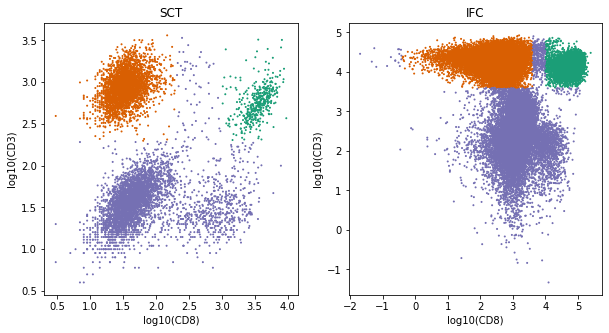

In [4]:
#%% sanity check: plot the gates
cmap = plt.cm.Dark2

#plot raw markers
fig, axes = plt.subplots(1,2,sharex=False,sharey=False,figsize=(10,5))
ax=axes[0]
#Categories (3, object): [CD3+CD8+, CD3+CD8-, unknown]
ax.scatter(adata.obs['CD8_log'],adata.obs['CD3_log'],c=cmap(y_gate_scRNAseq.cat.codes),s=1)
ax.set_title('SCT')
ax.set_xlabel('log10(CD8)')
ax.set_ylabel('log10(CD3)')
ax=axes[1]
#Categories (3, object): [CD3+CD8+, CD3+CD8-, unknown]
ax.scatter(cd8_img_log,cd3_img_log,c=cmap(y_gate_IFC.cat.codes),s=1)
ax.set_title('IFC')
ax.set_xlabel('log10(CD8)')
ax.set_ylabel('log10(CD3)')

## Predicting expression on IFC data with ifcseq.predict()
ifcseq.predict expects a numpy array of the surface markers for the IFC data, as well as a model trained with ifcseq, such as the random forest we trained above. We also saw that the surface markers have a different range of values between the SCT and IFC modalities, so we normalize both between zero and one to aid the model's predictions.

In [5]:
#normalize IFC markers to 0-1
X_ifc = np.concatenate((np.expand_dims(cd8_img_log,-1),
                        np.expand_dims(cd3_img_log,-1)),axis=-1)
X_ifc = normalize_markers_01(X_ifc)

#pridict with random forest by reading the model from disk
Y_ifc_RF = predict(X_ifc,model='./ifcseq_human_data/RFmodel.pkl')

loading model from disk, at: ./ifcseq_human_data/RFmodel.pkl
predicting gene expression


Now we convert the predictions to AnnData for convenience

In [6]:
adata_RF = sc.AnnData(X=Y_ifc_RF)
adata_RF.var_names = adata.var_names#fix the gene names
adata_RF.obs['celltype_gate'] = pd.Categorical(y_gate_IFC.values, categories=y_gate_IFC.cat.categories)
adata_RF.obs['cd3_log'] = cd3_img_log
adata_RF.obs['cd8_log'] = cd8_img_log

Let's plot the gene expression of select marker genes, as measured for the SCT data and as predicted by IFC-seq for the IFC data. We see that the expression patterns are similar across sub-populations of interest in both modalities

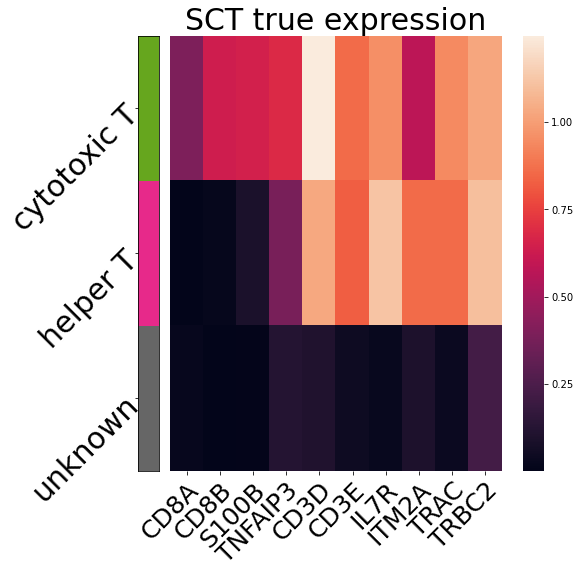

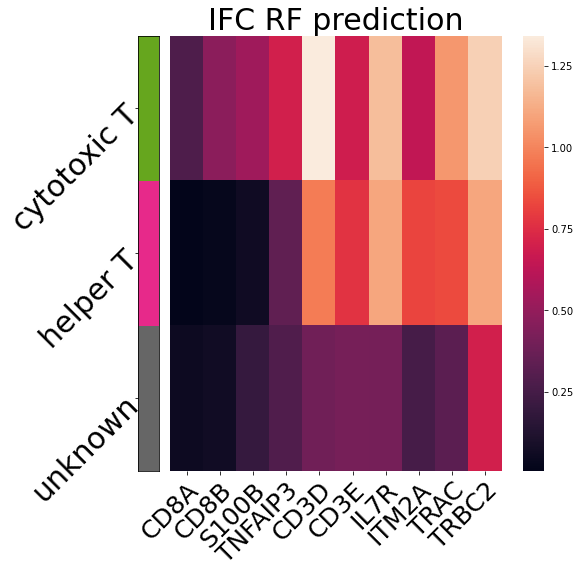

In [7]:
markers=['HUMAN_CD8A','HUMAN_CD8B','HUMAN_S100B','HUMAN_TNFAIP3',
         'HUMAN_CD3D','HUMAN_CD3E','HUMAN_IL7R','HUMAN_ITM2A','HUMAN_TRAC','HUMAN_TRBC2']

def plot_heatmap(adata_plot, markers, title):
    '''
    Plot a heatmap for the selected marker genes, averaged across populations
    '''
    # groups= adata_plot.obs['celltype_gate'].cat.categories.values.tolist()
    markers=['HUMAN_CD8A','HUMAN_CD8B','HUMAN_S100B','HUMAN_TNFAIP3',
             'HUMAN_CD3D','HUMAN_CD3E','HUMAN_IL7R','HUMAN_ITM2A','HUMAN_TRAC','HUMAN_TRBC2']#,
             #'HUMAN_CD14','HUMAN_CD19','HUMAN_ITGAM','HUMAN_FOXP1']
    markers_clean = [marker[6:] for marker in markers]#without the HUMAN_ prefix
    
    #X_sub = adata_plot[:,markers].X[ix_sorted,:]
    X_sub = adata_plot[:,markers].X
    
    G_mean = np.zeros((len(adata_plot.obs['celltype_gate'].cat.categories),
                       len(markers)))
    G_mean[0,:] = X_sub[adata_plot.obs['celltype_gate']=='CD3+CD8+',:].mean(axis=0)
    G_mean[1,:] = X_sub[adata_plot.obs['celltype_gate']=='CD3+CD8-',:].mean(axis=0)
    G_mean[2,:] = X_sub[adata_plot.obs['celltype_gate']=='unknown',:].mean(axis=0)
    
    plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(1, 2,
                           wspace=0.05,
                           width_ratios=[0.5, 10])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1]) 
    
    # group_marker=adata_plot.obs['celltype_gate'].values
    # ix_sorted = np.argsort(group_marker.codes)
    
    group_marker_colors=np.zeros((len(G_mean),1,4))
    group_marker_colors[1]=plt.cm.Dark2(3)
    group_marker_colors[0]=plt.cm.Dark2(4)
    group_marker_colors[2]=plt.cm.Dark2(7)
    
    ax0.imshow(group_marker_colors,aspect='auto',norm=None)
    ax0.set_xticks([])
    celltype_tics=[0,1,2]
    
    celltype_tics_labels=['cytotoxic T','helper T','unknown']
    ax0.set_yticks(celltype_tics)
    ax0.set_yticklabels(celltype_tics_labels,{'fontsize':30})
    plt.setp(ax0.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    ax1.set_title(title,{'fontsize':30})
    heatmap(G_mean,
            xticklabels=markers_clean,
            yticklabels='',
            ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),{'fontsize':25})
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")


plot_heatmap(adata, markers, title='SCT true expression')
plot_heatmap(adata_RF, markers, title='IFC RF prediction')
